# Práctica 3: Fundamentos CNN

En primer lugar vamos a tratar de resolver el problema de clasificación con la base de datos CIFAR 10 que no pudimos solventar en la práctica anterior empleando redes neuronales totalmente conectadas.

Para el desarrollo de esta práctica vamos a activar el uso de GPU.

Para ellos accede a: 


Entorno de ejecución

-> Cambiar tipo de entorno de ejecución

-> Acelerador por hardware

-> GPU

-> Guardar

In [1]:
# Importamos la base de datos
from tensorflow.keras.datasets import cifar10       # podemos ir a keras y ver las bases de datos incluidas

(X_train, y_train), (X_testval, y_testval) = cifar10.load_data()

print(X_train.shape, y_train.shape)
print(X_testval.shape, y_testval.shape)

print('Valor mínimo imágenes: ', X_train.min())
print('Valor máximo imágenes: ', X_train.max())

170508288/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3) (50000, 1)
(10000, 32, 32, 3) (10000, 1)
Valor mínimo imágenes:  0
Valor máximo imágenes:  255


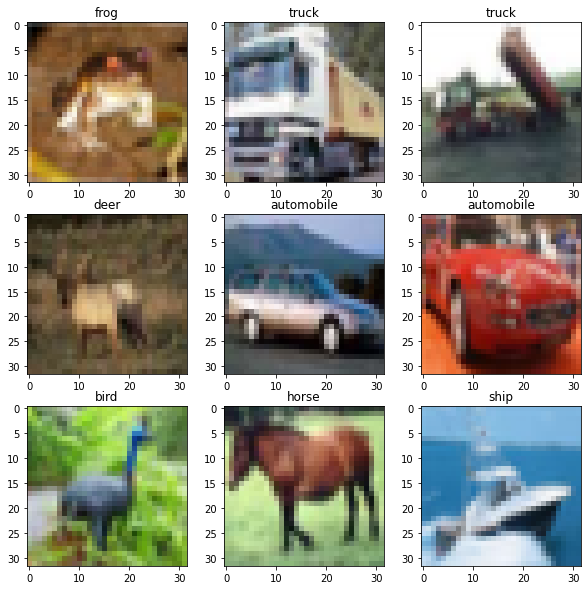

In [2]:
import matplotlib.pyplot as plt

# Vector de los nombres de las clases definidas en CIFAR
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 
           'horse', "ship", "truck"]

# Mostramos 9 imágenes
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(9):       # se puede cambiar para ver otras distintas  ej.: i+15
  plt.subplot(3, 3, i+1)
  plt.imshow(X_train[i])
  plt.title(f'{classes[int(y_train[i])]}')

In [3]:
# Convertimos rango imágenes a 0-1
X_train = X_train.astype('float32')
X_testval = X_testval.astype('float32')
X_train /= 255
X_testval /= 255

In [4]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder
# Convertimos etiquetas a codificación one-hot
from tensorflow.keras.utils import to_categorical
num_clases = len(np.unique(y_train))
y_train_cod = to_categorical(y_train, num_clases)
y_testval_cod = to_categorical(y_testval, num_clases)
print("Tamaño etiquetas entrenamiento: ", y_train_cod.shape)
print("Tamaño etiquetas validación/test: ", y_testval_cod.shape)

Tamaño etiquetas entrenamiento:  (50000, 10)
Tamaño etiquetas validación/test:  (10000, 10)


In [6]:
y_train_cod[5]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
# Dividimos conjunto de datos de validación/test en 2 subconjuntos
from sklearn.model_selection import train_test_split
X_val, X_test, y_val, y_test = train_test_split(X_testval, y_testval_cod,
                                                test_size=0.5)

print("Muestras validación: ", X_val.shape)
print("Salida validación: ", y_val.shape)
print("Muestras test: ", X_test.shape)
print("Salida test: ", y_test.shape)

Muestras validación:  (5000, 32, 32, 3)
Salida validación:  (5000, 10)
Muestras test:  (5000, 32, 32, 3)
Salida test:  (5000, 10)


In [ ]:
# Definimos la arquitectura     //hay dos formas de definirlo, Model y Sequential. El resultado es el mismo. Sequential se define al principio y Model al final.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense    #las capas que nos interesan. "Flatten" la convierte a un vector

# Extracción características
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))    #tamaño de la imagen, filas, columnas, canales //capa de entrada
conv1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_layer)         #se puede poner (8,(3,3)) y también activation se puede poner abajo //act1 = Activation("relu")(conv1)
max_pool1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)                      #con Model, hay que decirle la capa anterior al final con paréntesis

conv2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(max_pool1)     #cada vez que reduzco la imagen a la mitad (MaxPooling), el número de filtros x 2
max_pool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2)

conv3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(max_pool2)
max_pool3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv3)

# Clasificación
flatten_layer = Flatten()(max_pool3)     #convertir imagen que tengo a la salida en un vector.
hidden_layer = Dense(128, activation='relu')(flatten_layer)   # Capa oculta totalmente conectada 128 neuronas relu
output_layer = Dense(10, activation='softmax')(hidden_layer) # 10 salidas

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()  # el número de parámetros se dispara por las totalmente  conectadas

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 32)          4640  

In [ ]:
# Compilamos el modelo   (como siempre)
model.compile(loss="categorical_crossentropy", optimizer="adam",
              metrics=["accuracy"])

In [ ]:
# Entenamos el modelo   (es importante la GPU porque va más rápido)  ((dataset grande, pero imágenes pequeñas)) Entrenamientos que duran días.
history = model.fit(X_train, y_train_cod, epochs=20, batch_size=128,
                    validation_data=(X_val, y_val))

Epoch 1/20
391/391 [==============================] - 16s 9ms/step - loss: 1.8249 - accuracy: 0.3265 - val_loss: 1.6146 - val_accuracy: 0.4176
Epoch 2/20
391/391 [==============================] - 3s 8ms/step - loss: 1.4963 - accuracy: 0.4573 - val_loss: 1.4464 - val_accuracy: 0.4822
Epoch 3/20
391/391 [==============================] - 3s 8ms/step - loss: 1.3791 - accuracy: 0.5064 - val_loss: 1.3847 - val_accuracy: 0.5116
Epoch 4/20
391/391 [==============================] - 3s 8ms/step - loss: 1.3141 - accuracy: 0.5320 - val_loss: 1.3420 - val_accuracy: 0.5228
Epoch 5/20
391/391 [==============================] - 3s 8ms/step - loss: 1.2711 - accuracy: 0.5485 - val_loss: 1.2834 - val_accuracy: 0.5448
Epoch 6/20
391/391 [==============================] - 3s 8ms/step - loss: 1.2352 - accuracy: 0.5633 - val_loss: 1.2677 - val_accuracy: 0.5512
Epoch 7/20
391/391 [==============================] - 3s 8ms/step - loss: 1.1996 - accuracy: 0.5761 - val_loss: 1.2277 - val_accuracy: 0.5676
Epoch

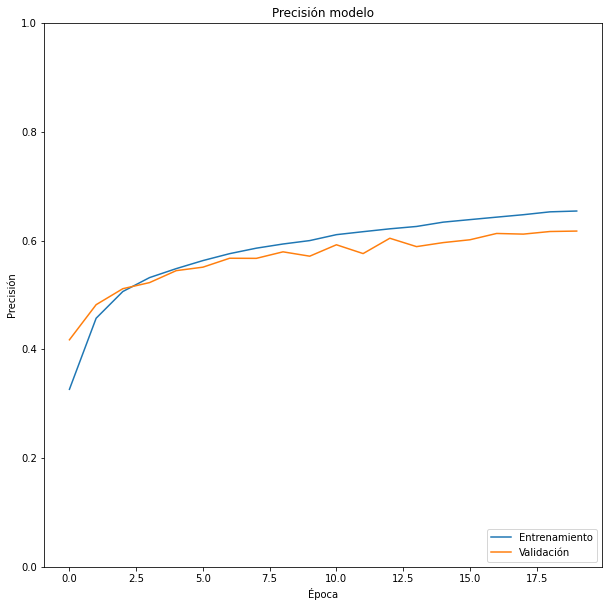

In [ ]:
# Visualizamos la exactitud ((NO hay sobreajuste))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Exactitud modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Entrenamiento', 'Validación'], loc="lower right")
plt.show()

In [ ]:
# Evaluamos modelos     (62% en inferencia (como en validación))
metrics = model.evaluate(X_test, y_test, verbose=0)
print('Exactitud test: ', metrics[1])

Precisión test:  0.6212000250816345


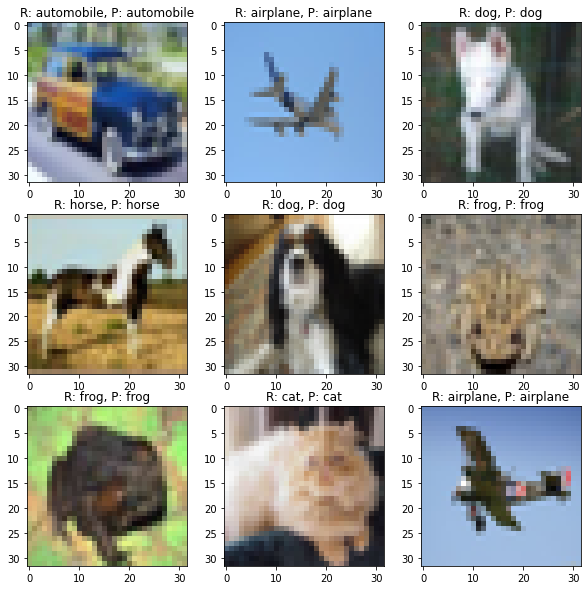

In [ ]:
import numpy as np

# Obtenemos predicciones 
prediccion = model.predict(X_test)
# Cogemos la clase con mayor probabilidad
prediccion = np.argmax(prediccion, axis=1)

# y_test lo tenemos en codificación OneHot, por lo que lo convertimos a clases
y_test_clases = np.argmax(y_test, axis=1)

# Buscamos los índices de las imágenes corretamente e incorrectamente clasificadas  (aviones, camiones)
correct_index = np.nonzero(prediccion == y_test_clases)[0]
incorrect_index = np.nonzero(prediccion != y_test_clases)[0]

# Mostramos 9 imágenes correctamente clasifcadas
plt.rcParams['figure.figsize'] = (10, 10)
for i, correct in enumerate(correct_index[:9]):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[correct])
  plt.title(f'R: {classes[int(y_test_clases[correct])]}, P: {classes[int(prediccion[correct])]}')

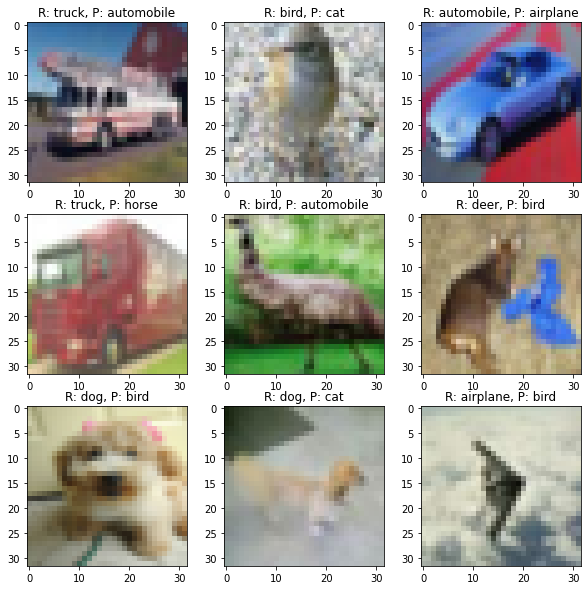

In [ ]:
# Mostramos 9 imágenes incorrectamente clasificadas   ((las más interesantes))  //tampoco ha sido el mejor modelo de nuestra vida.
for i, incorrect in enumerate(incorrect_index[:9]):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[incorrect])
  plt.title(f'R: {classes[int(y_test_clases[incorrect])]}, P: {classes[int(prediccion[incorrect])]}')

# Ejercicio 1: Entramiento durante más épocas
Vamos a entrenar el modelo durante 50 épocas

NOTA: Para cada ejercicio genera una modelo diferente (con distinto nombre ej. "model_2") porque se guarda los parámetros y si siempre se llama igual (model por ejemplo), pues puede dar problemas.

In [ ]:
# Creamos el modelo con la misma arquitectura que antes
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
conv1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_layer)
max_pool1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)

conv2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(max_pool1)
max_pool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2)

conv3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(max_pool2)
max_pool3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv3)

flatten_layer = Flatten()(max_pool3) 
hidden_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(10, activation='softmax')(hidden_layer) # 10 salidas

model_2 = Model(inputs=input_layer, outputs=output_layer)

# Compilamos el modelo
model_2.compile(loss="categorical_crossentropy", optimizer="adam",
                metrics=["accuracy"])
# Entrenamos
history_2 = model_2.fit(X_train, y_train_cod, epochs=50, batch_size=128,   #cambiamos las épocas
                        validation_data=(X_val, y_val))

Epoch 1/50
391/391 [==============================] - 4s 9ms/step - loss: 1.8137 - accuracy: 0.3324 - val_loss: 1.6046 - val_accuracy: 0.4096
Epoch 2/50
391/391 [==============================] - 3s 8ms/step - loss: 1.5087 - accuracy: 0.4540 - val_loss: 1.4321 - val_accuracy: 0.4840
Epoch 3/50
391/391 [==============================] - 3s 8ms/step - loss: 1.3783 - accuracy: 0.5068 - val_loss: 1.3528 - val_accuracy: 0.5200
Epoch 4/50
391/391 [==============================] - 3s 8ms/step - loss: 1.2880 - accuracy: 0.5426 - val_loss: 1.2841 - val_accuracy: 0.5386
Epoch 5/50
391/391 [==============================] - 3s 8ms/step - loss: 1.2296 - accuracy: 0.5650 - val_loss: 1.2350 - val_accuracy: 0.5628
Epoch 6/50
391/391 [==============================] - 3s 8ms/step - loss: 1.1793 - accuracy: 0.5833 - val_loss: 1.2090 - val_accuracy: 0.5714
Epoch 7/50
391/391 [==============================] - 3s 9ms/step - loss: 1.1483 - accuracy: 0.5974 - val_loss: 1.1719 - val_accuracy: 0.5888
Epoch 

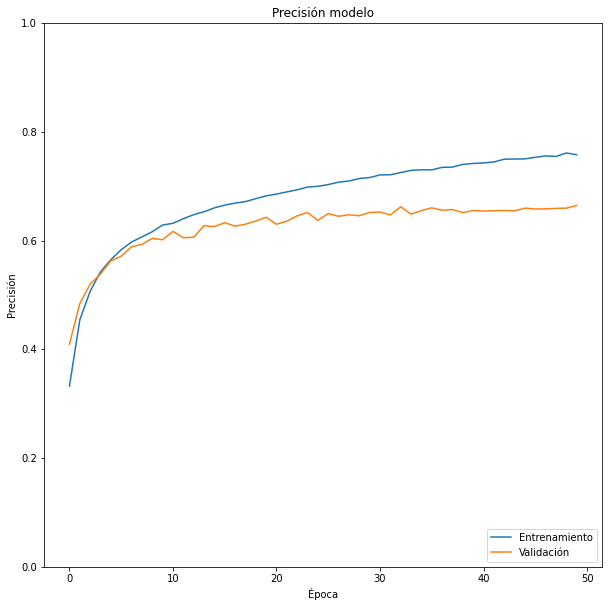

In [ ]:
# Visualizamos la exactitud
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Exactitud modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Entrenamiento', 'Validación'], loc="lower right")
plt.show()

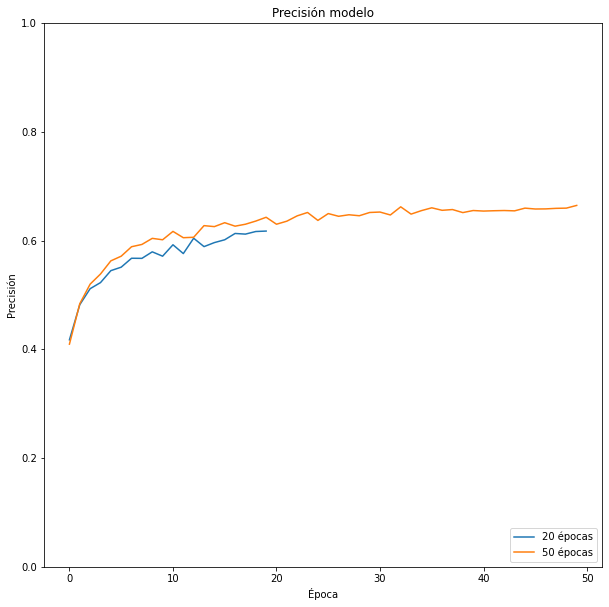

In [ ]:
# Comparamos con la exactitud anterior en validación
plt.plot(history.history['val_accuracy'])
plt.plot(history_2.history['val_accuracy'])
plt.title('Exactitud modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['20 épocas', '50 épocas'], loc="lower right")
plt.show()

In [ ]:
# Comparamos métricas entrenamiento y validación
print('Exactitud modelo 20 épocas: ')
print(' - Entrenamiento: ', history.history['accuracy'][-1])
print(' - Validación: ', history.history['val_accuracy'][-1])
print('Exactitud modelo 50 épocas: ')
print(' - Entrenamiento: ', history_2.history['accuracy'][-1])
print(' - Validación: ', history_2.history['val_accuracy'][-1])

Precisión modelo 20 épocas: 
 - Entrenamiento:  0.65447998046875
 - Validación:  0.6176000237464905
Precisión modelo 50 épocas: 
 - Entrenamiento:  0.7580400109291077
 - Validación:  0.6647999882698059


In [ ]:
# Comparamos métricas test
metrics_2 = model_2.evaluate(X_test, y_test, verbose=0)
print('Exactitud modelo inicial en test: ', metrics[1])
print('Exactitud modelo con más épocas: ', metrics_2[1])

Precisión modelo inicial en test:  0.6212000250816345
Precisión modelo con más épocas:  0.6697999835014343


Con más épocas el modelo ha conseguido obtener mejor exactitud tanto en validación como en test.
Establecer correctamente el número de épocas es importante para asegurarnos que no "cortamos el aprendizaje a mitad - subajuste" pero sin llegar a sobreajustar demasiado.
Para esto usar callbacks como el de EarlyStopping que vimos la semana pasada es de gran utilidad.

Llega un momento que crece muy poco a poco.


# Ejercicio 2: Doblamos el número de filtros en cada capa convolucional

Vamos a aumentar la complejidad de la arquitectura. Primero vamos a doblar el número de filtros de cada capa convolucional:
- conv1: 8 -> 16
- conv2: 16 -> 32
- conv3: 32 -> 64

Para estas pruebas vuelve a poner el número de épocas a 20 para que los experimentos vayan más rápido.

In [ ]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
conv1 = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(input_layer)
max_pool1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)

conv2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(max_pool1)
max_pool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2)

conv3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(max_pool2)
max_pool3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv3)

# Clasificación
flatten_layer = Flatten()(max_pool3) 
hidden_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(10, activation='softmax')(hidden_layer) # 10 salidas

model_3 = Model(inputs=input_layer, outputs=output_layer)

model_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 30, 30, 16)        448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 15, 15, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          1849

- Modelo inicial: 23834 parámetros
- Modelo con el doble de filtros: 57770 parámetros

En redes totalmente conectadas (práctica2), eran casi 500.000 parámetros. En la CNN utilizamos la imagen en total y reducimos la cantidad de parámetros a entrenar.

In [ ]:
# Compilamos el modelo
model_3.compile(loss="categorical_crossentropy", optimizer="adam",
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(X_train, y_train_cod, epochs=20, batch_size=128,
                      validation_data=(X_val, y_val))

Epoch 1/20
391/391 [==============================] - 5s 11ms/step - loss: 1.7348 - accuracy: 0.3629 - val_loss: 1.4665 - val_accuracy: 0.4748
Epoch 2/20
391/391 [==============================] - 4s 10ms/step - loss: 1.4088 - accuracy: 0.4905 - val_loss: 1.3492 - val_accuracy: 0.5176
Epoch 3/20
391/391 [==============================] - 4s 11ms/step - loss: 1.2639 - accuracy: 0.5480 - val_loss: 1.2916 - val_accuracy: 0.5394
Epoch 4/20
391/391 [==============================] - 4s 10ms/step - loss: 1.1715 - accuracy: 0.5857 - val_loss: 1.1640 - val_accuracy: 0.5828
Epoch 5/20
391/391 [==============================] - 4s 11ms/step - loss: 1.1093 - accuracy: 0.6095 - val_loss: 1.1253 - val_accuracy: 0.6092
Epoch 6/20
391/391 [==============================] - 4s 10ms/step - loss: 1.0451 - accuracy: 0.6337 - val_loss: 1.0762 - val_accuracy: 0.6220
Epoch 7/20
391/391 [==============================] - 4s 10ms/step - loss: 1.0002 - accuracy: 0.6499 - val_loss: 1.0756 - val_accuracy: 0.6240

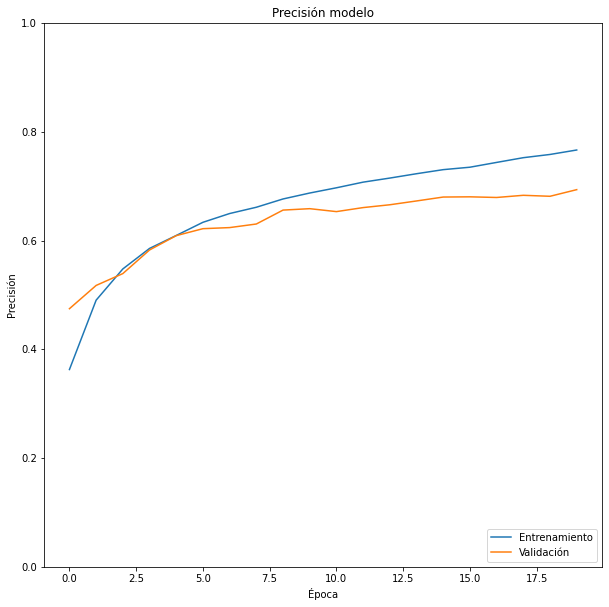

In [ ]:
# Visualizamos la exactitud
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Exactitud modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Entrenamiento', 'Validación'], loc="lower right")
plt.show()

In [ ]:
# Comparamos métricas entrenamento/validación con modelo inicial
print('Exactitud modelo inicial: ')
print(' - Entrenamiento: ', history.history['accuracy'][-1])
print(' - Validación: ', history.history['val_accuracy'][-1])
print('Exactitud modelo con el doble de filtros en cada capa convolucional: ')
print(' - Entrenamiento: ', history_3.history['accuracy'][-1])
print(' - Validación: ', history_3.history['val_accuracy'][-1])

Precisión modelo inicial: 
 - Entrenamiento:  0.65447998046875
 - Validación:  0.6176000237464905
Precisión modelo con el doble de filtros en cada capa convolucional: 
 - Entrenamiento:  0.7667400240898132
 - Validación:  0.6937999725341797


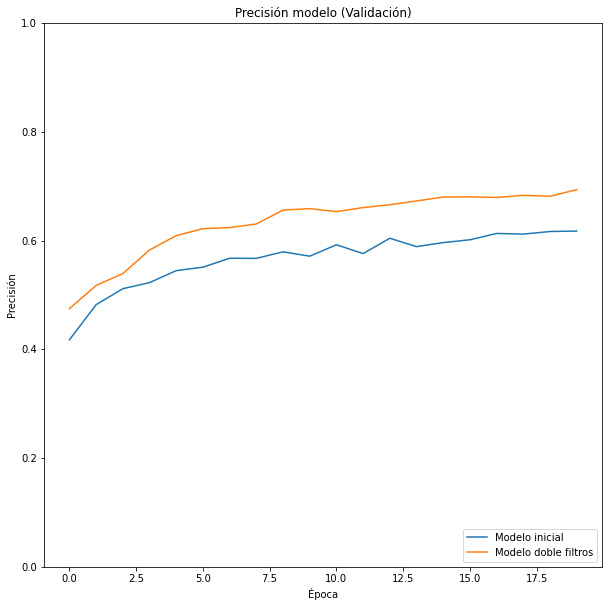

In [ ]:
# Comparamos las métricas en validación
plt.plot(history.history['val_accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Exactitud modelo (Validación)')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Modelo inicial', 'Modelo doble filtros'], loc="lower right")
plt.show()

In [ ]:
metrics_3 = model_3.evaluate(X_test, y_test, verbose=0)
print('Exactitud modelo inicial en test: ', metrics[1])
print('Exactitud modelo con doble de filtros en test: ', metrics_3[1])

Precisión modelo inicial en test:  0.6212000250816345
Precisión modelo con doble de filtros en test:  0.6948000192642212


Aumentando la complejidad del modelo hemos mejorado la exactidud del modelo

# Ejercicio 3. Aumentamos el número de capas convolucionales.
Tomando como partida el modelo inicial, donde ahora tenemos una capa convolucional añade otra justo antes con el mismo número de filtros y padding "same" (tamaño de salida igual al tamaño de entrada).

In [ ]:
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
conv1_1 = Conv2D(filters=8, kernel_size=(3,3), padding='same', activation='relu')(input_layer)
conv1_2 = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(conv1_1)
max_pool1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1_2)

conv2_1 = Conv2D(filters=16, kernel_size=(3,3), padding='same', activation='relu')(max_pool1)
conv2_2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(conv2_1)
max_pool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2_2)

conv3_1 = Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu')(max_pool2)
conv3_2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(conv3_1)
max_pool3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv3_2)

# Clasificación
flatten_layer = Flatten()(max_pool3) 
hidden_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(10, activation='softmax')(hidden_layer) # 10 salidas

model_4 = Model(inputs=input_layer, outputs=output_layer)

model_4.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 conv2d_10 (Conv2D)          (None, 30, 30, 8)         584       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 8)        0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 15, 15, 16)        1168      
                                                                 
 conv2d_12 (Conv2D)          (None, 13, 13, 16)        2320      
                                                           

In [ ]:
# Compilamos el modelo
model_4.compile(loss="categorical_crossentropy", optimizer="adam",
                metrics=["accuracy"])

In [ ]:
history_4 = model_4.fit(X_train, y_train_cod, epochs=20, batch_size=128,
                        validation_data=(X_val, y_val))

Epoch 1/20
391/391 [==============================] - 7s 15ms/step - loss: 1.8384 - accuracy: 0.3241 - val_loss: 1.6580 - val_accuracy: 0.3968
Epoch 2/20
391/391 [==============================] - 5s 12ms/step - loss: 1.5211 - accuracy: 0.4486 - val_loss: 1.4281 - val_accuracy: 0.4844
Epoch 3/20
391/391 [==============================] - 5s 12ms/step - loss: 1.3577 - accuracy: 0.5100 - val_loss: 1.3689 - val_accuracy: 0.5074
Epoch 4/20
391/391 [==============================] - 5s 12ms/step - loss: 1.2632 - accuracy: 0.5467 - val_loss: 1.2400 - val_accuracy: 0.5680
Epoch 5/20
391/391 [==============================] - 5s 12ms/step - loss: 1.1801 - accuracy: 0.5768 - val_loss: 1.1636 - val_accuracy: 0.5936
Epoch 6/20
391/391 [==============================] - 5s 12ms/step - loss: 1.1198 - accuracy: 0.6008 - val_loss: 1.1699 - val_accuracy: 0.5912
Epoch 7/20
391/391 [==============================] - 5s 12ms/step - loss: 1.0709 - accuracy: 0.6187 - val_loss: 1.1213 - val_accuracy: 0.6044

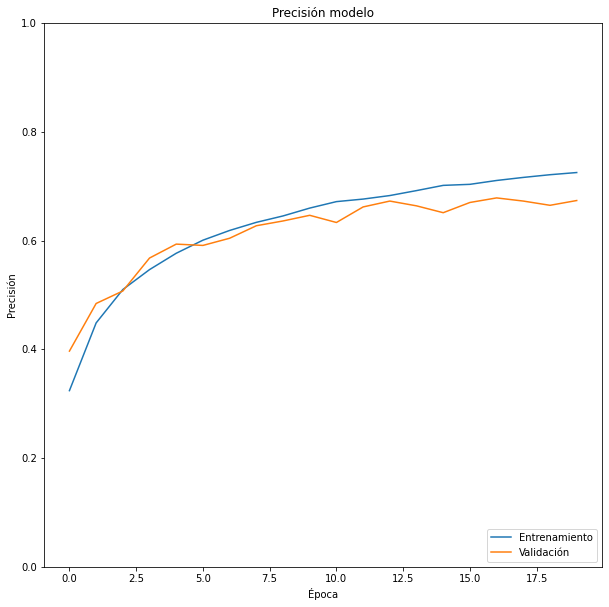

In [ ]:
# Visualizamos la exactitud
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Exactitud modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Entrenamiento', 'Validación'], loc="lower right")
plt.show()

In [ ]:
# Comparamos métricas entrenamento/validación con modelo inicial
print('Exactitud modelo inicial: ')
print(' - Entrenamiento: ', history.history['accuracy'][-1])
print(' - Validación: ', history.history['val_accuracy'][-1])
print('Exactitud modelo con el doble de filtros en cada capa convolucional: ')
print(' - Entrenamiento: ', history_4.history['accuracy'][-1])
print(' - Validación: ', history_4.history['val_accuracy'][-1])

Precisión modelo inicial: 
 - Entrenamiento:  0.65447998046875
 - Validación:  0.6176000237464905
Precisión modelo con el doble de filtros en cada capa convolucional: 
 - Entrenamiento:  0.7252799868583679
 - Validación:  0.673799991607666


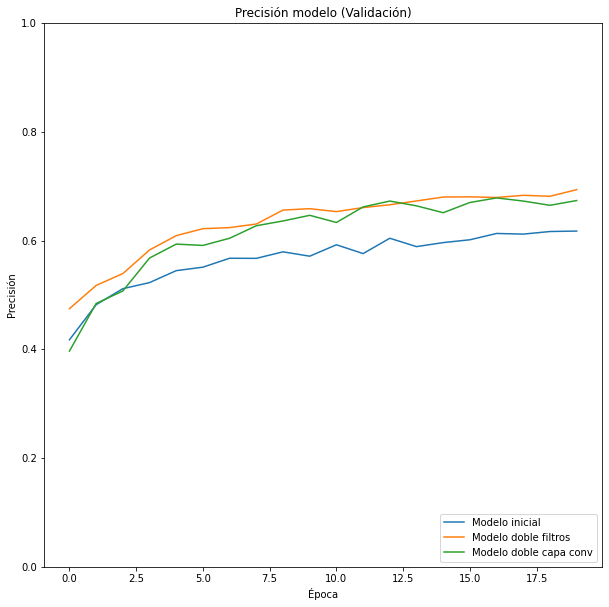

In [ ]:
# Comparamos las métricas en validación de los 3 modelos
plt.plot(history.history['val_accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Exactitud modelo (Validación)')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Modelo inicial', 'Modelo doble filtros', 'Modelo doble capa conv'], loc="lower right")
plt.show()

In [ ]:
# Evaluamos sobre el conjunto de test y comparamos con modelos anteriores
metrics_4 = model_4.evaluate(X_test, y_test, verbose=0)
print('Exactitud modelo inicial (test): ', metrics[1])
print('Exactitud modelo con doble de filtros (test): ', metrics_3[1])
print('Exactitud modelo con doble capas convolucionales (test): ', metrics_4[1])

Precisión modelo inicial (test):  0.6212000250816345
Precisión modelo con doble de filtros (test):  0.6948000192642212
Precisión modelo con doble capas convolucionales (test):  0.6733999848365784


Da mejores resultados conforme vamos aumentando la complejidad del modelo.

# Ejercicio 4: Aumentamos el tamaño de batch del modelo inicial
Vamos a cambiar el tamaño de batch a 250.

In [ ]:
# Definimos arquitectura
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
conv1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_layer)
max_pool1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)

conv2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(max_pool1)
max_pool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2)

conv3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(max_pool2)
max_pool3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv3)

flatten_layer = Flatten()(max_pool3) 
hidden_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(10, activation='softmax')(hidden_layer) # 10 salidas

model_5 = Model(inputs=input_layer, outputs=output_layer)

# Compilamos el modelo
model_5.compile(loss="categorical_crossentropy", optimizer="adam",
                metrics=["accuracy"])
# Entrenamos
history_5 = model_5.fit(X_train, y_train_cod, epochs=20, batch_size=250,
                      validation_data=(X_val, y_val))

Epoch 1/20
200/200 [==============================] - 3s 12ms/step - loss: 1.8866 - accuracy: 0.2913 - val_loss: 1.6739 - val_accuracy: 0.3754
Epoch 2/20
200/200 [==============================] - 2s 10ms/step - loss: 1.5967 - accuracy: 0.4123 - val_loss: 1.5430 - val_accuracy: 0.4262
Epoch 3/20
200/200 [==============================] - 2s 10ms/step - loss: 1.4855 - accuracy: 0.4591 - val_loss: 1.4643 - val_accuracy: 0.4684
Epoch 4/20
200/200 [==============================] - 2s 10ms/step - loss: 1.4082 - accuracy: 0.4901 - val_loss: 1.4362 - val_accuracy: 0.4888
Epoch 5/20
200/200 [==============================] - 2s 11ms/step - loss: 1.3465 - accuracy: 0.5128 - val_loss: 1.3507 - val_accuracy: 0.5066
Epoch 6/20
200/200 [==============================] - 2s 11ms/step - loss: 1.2984 - accuracy: 0.5365 - val_loss: 1.3074 - val_accuracy: 0.5318
Epoch 7/20
200/200 [==============================] - 2s 11ms/step - loss: 1.2561 - accuracy: 0.5541 - val_loss: 1.3148 - val_accuracy: 0.5354

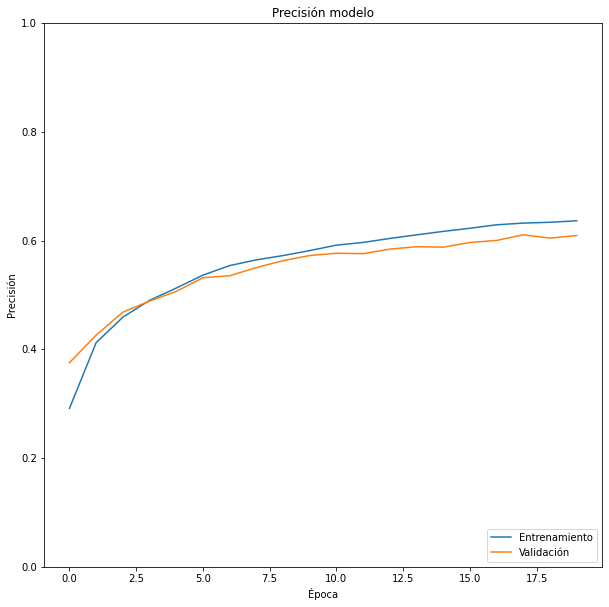

In [ ]:
# Visualizamos la exactitud
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Exactitud modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Entrenamiento', 'Validación'], loc="lower right")
plt.show()

In [ ]:
# Comparamos métricas entrenamento/validación con modelo inicial
print('Exactitud modelo inicial (batch 128): ')
print(' - Entrenamiento: ', history.history['accuracy'][-1])
print(' - Validación: ', history.history['val_accuracy'][-1])
print('Exactitud modelo con batch de 250: ')
print(' - Entrenamiento: ', history_5.history['accuracy'][-1])
print(' - Validación: ', history_5.history['val_accuracy'][-1])

Precisión modelo inicial (batch 128): 
 - Entrenamiento:  0.65447998046875
 - Validación:  0.6176000237464905
Precisión modelo con batch de 250: 
 - Entrenamiento:  0.63646000623703
 - Validación:  0.6093999743461609


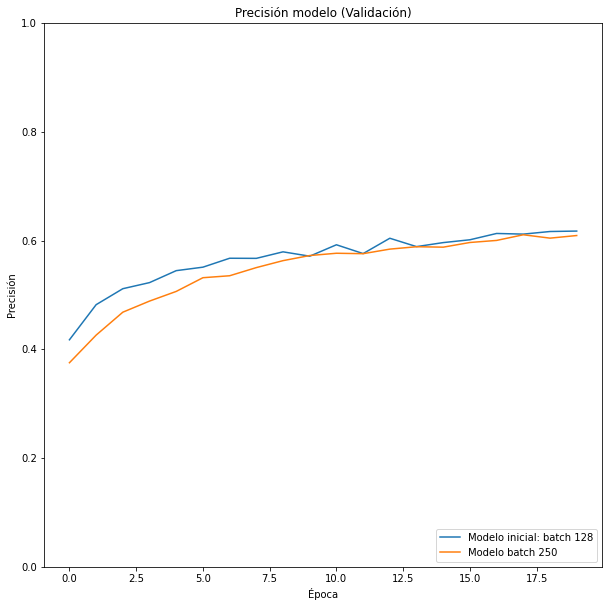

In [ ]:
# Comparamos las métricas en validación con el modelo inicia,
plt.plot(history.history['val_accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Exactitud modelo (Validación)')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Modelo inicial: batch 128', 'Modelo batch 250'], loc="lower right")
plt.show()

In [ ]:
# Evaluamos sobre el conjunto de test y comparamos con modelo inicial
metrics_5 = model_5.evaluate(X_test, y_test, verbose=0)
print('Exactitud modelo inicial batch 128 (test): ', metrics[1])
print('Exactitud modelo con batch 250 (test): ', metrics_5[1])

Precisión modelo inicial batch 128 (test):  0.6212000250816345
Precisión modelo con batch 250 (test):  0.6313999891281128


Resultados muy parecidos.

Puede parecer intuitivo que si ampliamos el tamaño de batch los resultados serán mejores ya que el modelo "ve" más imágenes de una. Pero esto no siempre es así. Hay que seleccionar el tamaño de batch con cuidado. Mayor estabilidad

# Aumento de datos

In [ ]:
# Definimos generador de datos    ((librería ImageDataGenerator))
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(    #podemos utilizar distintas técnicas de transformación de los datos
                                    rotation_range=5, 
                                    horizontal_flip=True,
                                    zoom_range=.3)

train_generator.fit(X_train)

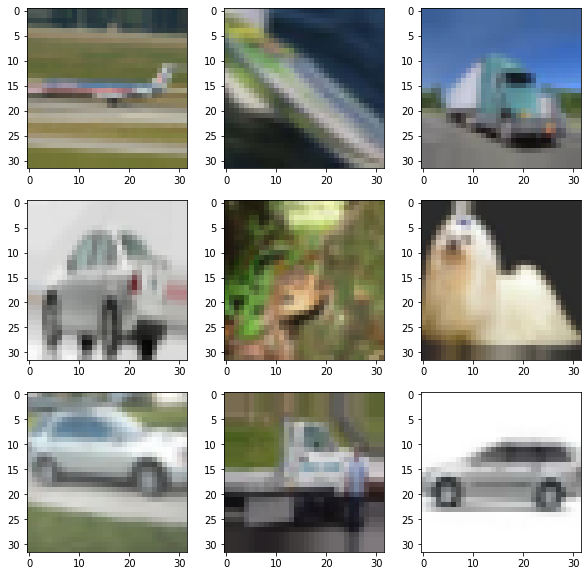

In [ ]:
# Visualizamos imágenes aumentadas
augmented_images, _ = next( train_generator.flow(X_train, y_train_cod, batch_size=9))
plt.rcParams['figure.figsize'] = (10, 10)
for i in range(9):
  plt.subplot(3, 3, i+1)
  plt.imshow(augmented_images[i, :, :, :])

In [ ]:
# Definimos arquitectura
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]))
conv1 = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(input_layer)
max_pool1 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)

conv2 = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(max_pool1)
max_pool2 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2)

conv3 = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(max_pool2)
max_pool3 = MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv3)

flatten_layer = Flatten()(max_pool3) 
hidden_layer = Dense(128, activation='relu')(flatten_layer)
output_layer = Dense(10, activation='softmax')(hidden_layer) # 10 salidas

model_6 = Model(inputs=input_layer, outputs=output_layer)

# Compilamos el modelo
model_6.compile(loss="categorical_crossentropy", optimizer="adam",
                metrics=["accuracy"])
# Entrenamos
# ahora es fit, antes fit_generator
history_6 = model_6.fit_generator(train_generator.flow(X_train, y_train_cod, batch_size=128),    #flow genera los datos
                                            epochs=20,
                                            steps_per_epoch=X_train.shape[0] // 128,     #steps_per_epoch hay que añadirlo cuando utilizo un generador. (número total de imágenes que tengo entre el tamaño de batch)
                                            validation_data=(X_val, y_val))

# 20 segundos por cada época. Da un pelín peor, casi igual, incluso la mejora, sólo un pelín mejor.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/20
390/390 [==============================] - 30s 76ms/step - loss: 1.8585 - accuracy: 0.3175 - val_loss: 1.6155 - val_accuracy: 0.4116
Epoch 2/20
390/390 [==============================] - 45s 115ms/step - loss: 1.6030 - accuracy: 0.4185 - val_loss: 1.5163 - val_accuracy: 0.4560
Epoch 3/20
390/390 [==============================] - 31s 78ms/step - loss: 1.5166 - accuracy: 0.4559 - val_loss: 1.4567 - val_accuracy: 0.4770
Epoch 4/20
390/390 [==============================] - 29s 73ms/step - loss: 1.4522 - accuracy: 0.4812 - val_loss: 1.3810 - val_accuracy: 0.5024
Epoch 5/20
390/390 [==============================] - 29s 74ms/step - loss: 1.4035 - accuracy: 0.4990 - val_loss: 1.4040 - val_accuracy: 0.5008
Epoch 6/20
390/390 [==============================] - 40s 103ms/step - loss: 1.3666 - accuracy: 0.5152 - val_loss: 1.3398 - val_accuracy: 0.5218
Epoch 7/20
390/390 [==============================] - 33s 86ms/step - loss: 1.3316 - accuracy: 0.5285 - val_loss: 1.2947 - val_accurac

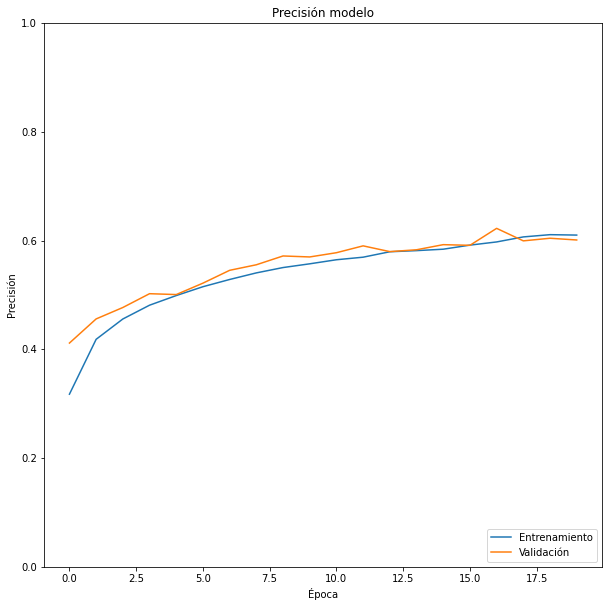

In [ ]:
# Visualizamos la exactitud
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Exactitud modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Entrenamiento', 'Validación'], loc="lower right")
plt.show()

In [ ]:
# Comparamos métricas entrenamento/validación con modelo inicial
print('Exactitud modelo inicial: ')
print(' - Entrenamiento: ', history.history['accuracy'][-1])
print(' - Validación: ', history.history['val_accuracy'][-1])
print('Exactitud modelo con aumento de datos: ')
print(' - Entrenamiento: ', history_6.history['accuracy'][-1])
print(' - Validación: ', history_6.history['val_accuracy'][-1])

Precisión modelo inicial: 
 - Entrenamiento:  0.65447998046875
 - Validación:  0.6176000237464905
Precisión modelo con aumento de datos: 
 - Entrenamiento:  0.6102221608161926
 - Validación:  0.6011999845504761


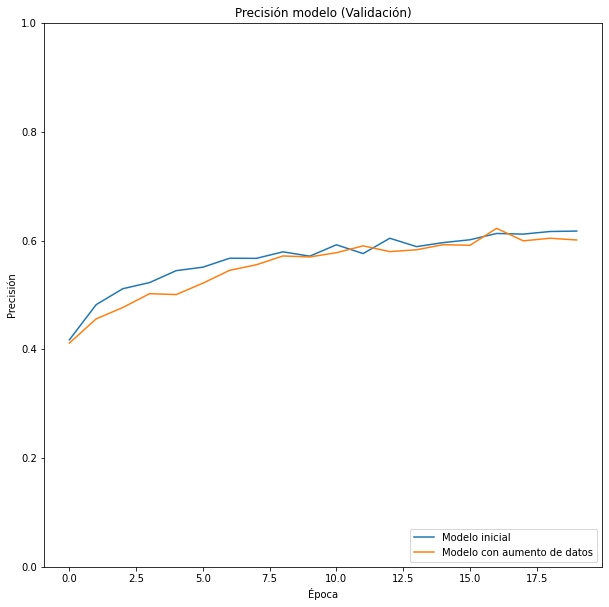

In [ ]:
# Comparamos las métricas en validación con el modelo inicia,
plt.plot(history.history['val_accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Exactitud modelo (Validación)')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.ylim(0,1)
plt.legend(['Modelo inicial', 'Modelo con aumento de datos'], loc="lower right")
plt.show()

In [ ]:
# Evaluamos sobre el conjunto de test y comparamos con modelo inicial
metrics_6 = model_6.evaluate(X_test, y_test, verbose=0)
print('Exactitud modelo inicial (test): ', metrics[1])
print('Exactitud modelo con aumento de datos (test): ', metrics_6[1])

Precisión modelo inicial (test):  0.6212000250816345
Precisión modelo con aumento de datos (test):  0.6194000244140625


Tras aplicar aumento de datos no observamos una mejora, un poquito peor la exactitud.

Merece la pena el aumento de datos en bases de datos pequeñitas ;-)

Investiga el método de DataGenerator y prueba con más transformaciones. ¡Incluso es posible aplicar aumento de datos al set de validación!

# Transferencia de conocimiento

En este apartado vamos a aplicar tranferencia de conocimiento empleando un modelo pre-entrenado en la base de datos de Imagenet. Concretamente emplearemos el modelo ResNet50 (no es la que mejor resultados, después de esta salieron más arquitecturas). ((buscar en internet [keras applications](https://keras.io/api/applications/)))

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np

# Volvemos al rango inicial de la imágenes [0-255] ya que se van a preprocesar de acuerdo a las necesidades de la red.
X_train *= 255
X_val *= 255
X_test *= 255
print("Rango imágenes: [", X_train.min(), ', ', X_train.max(),']')

# Si lo hacemos desde el principio no haría falta
# Preprocesamos los datos para que se ajusten a las necesidades del modelo selecccionado. "preprocess_input"
X_train_prep = preprocess_input(X_train)
X_val_prep = preprocess_input(X_val)
X_test_prep = preprocess_input(X_test)

print('Tamaño imágenes entrenamiento: ', X_train_prep.shape)
print('Valor mínimo imágenes entrenamiento: ', X_train_prep.min())    #NO sólo entre 0 y 255, también valores negativos. Ej. aplicando una normalización antes.
print('Valor máximo imágenes entrenamiento: ', X_train_prep.max())    #a la arquitectura le da igual valores negativos.

Rango imágenes: [ 0.0 ,  255.0 ]
Tamaño imágenes entrenamiento:  (50000, 32, 32, 3)
Valor mínimo imágenes entrenamiento:  -123.68
Valor máximo imágenes entrenamiento:  151.061


In [ ]:
from tensorflow.keras.applications import ResNet50    #antes era from keras.applications import ResNet50, ahora keras dentro de tensorflow

# Cogemos modelo base a utilizar (ResNet50).
# Con include_top=False le estamos indicando que no queremos incluir la última capa (FC clasificación final)
# Con weights='imagenet' le estamos indicando que queremos inicializar los pesos con los que se obtuvieron en el entrenamiento con la BBDD de Imagenet.
base_model = ResNet50(include_top=False,weights='imagenet', input_shape=(32,32,3))    #include_top=False, no pone la última capa totalmente conectada (1.000 de imagenet). weights, pongo los pesos de cuando entrenó "imagenet" y el input_shape, tamaño de mis imágenes de entrada. Así adaptará los filtros a ese tamaño.
base_model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                          

Add, la unión de varios bloques (conexión puente). Simulamos más profundidad con menos capas.

No vamos a usar todas las capas de ResNet ya que podemos ver que muchos de los bloques acaban teniendo un tamaño de imagen de 1x1. Esto es debido a que las imágenes de CIFAR son mucho más pequeñas (32x32) que las de ImageNet (224x224).

Vamos a coger hasta la capa "conv3_block4_out", que tiene un tamaño de imagen de 2x2 y vamos a congelar todas las capas. Es decir, durante el entrenamiento, los pesos de estas capas no se van a alterar, vamos a dejar los obtenidos en el entrenamiento con la base de datos de ImageNet. 
A estas capas les vamos a incluir, a la salida, una fase de clasificación, que será aquello que entrenaremos.

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout

# Congelamos todas las capas del clasificador VGG

# Cogemos la salida de la capa "conv3_block4_out"
#x = base_model.output
x = base_model.get_layer('conv3_block4_out').output

# Añadimos capas de clasificación
x = GlobalAveragePooling2D()(x)  #de una imagen genera un vector.
x = Dense(128, activation='relu')(x)  #añadimos capa oculta
x = Dropout(0.5)(x)   #añadimos dropout
output_layer = Dense(10, activation='softmax')(x)  #añadimos una capa densa que es la capa de salida con las 10 clases
model_resnet = Model(inputs=base_model.input, outputs=output_layer)   #generamos el modelo.

for layer in base_model.layers:    #congelamos las capas. Ponemos que NO son entrenables.
     layer.trainable = False

model_resnet.summary()



Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

¡Fijaros en el número de parámetros entrenables! (de 23.000.000, 67.000, al haberlos congelado). Todos los de ResNet no se van a alterar, únicamente los que hemos añadido con la capa totalmente conectada.

In [ ]:
# Compilamos el modelo
model_resnet.compile(loss="categorical_crossentropy", optimizer="adam",
                  metrics=["accuracy"])

In [ ]:
# Entenamos el modelo
history_resnet = model_resnet.fit(X_train_prep, y_train_cod, epochs=20,    #mismo tamaño del batch y mismos epochs
                                  batch_size=128,
                                  validation_data=(X_val_prep, y_val))

Epoch 1/20
391/391 [==============================] - 13s 26ms/step - loss: 1.4823 - accuracy: 0.4685 - val_loss: 1.0326 - val_accuracy: 0.6380
Epoch 2/20
391/391 [==============================] - 10s 25ms/step - loss: 1.1722 - accuracy: 0.5856 - val_loss: 0.9527 - val_accuracy: 0.6696
Epoch 3/20
391/391 [==============================] - 11s 28ms/step - loss: 1.1030 - accuracy: 0.6090 - val_loss: 0.9382 - val_accuracy: 0.6742
Epoch 4/20
391/391 [==============================] - 12s 30ms/step - loss: 1.0664 - accuracy: 0.6265 - val_loss: 0.8866 - val_accuracy: 0.6908
Epoch 5/20
391/391 [==============================] - 11s 27ms/step - loss: 1.0356 - accuracy: 0.6354 - val_loss: 0.8626 - val_accuracy: 0.7004
Epoch 6/20
391/391 [==============================] - 10s 27ms/step - loss: 1.0123 - accuracy: 0.6451 - val_loss: 0.8476 - val_accuracy: 0.7026
Epoch 7/20
391/391 [==============================] - 10s 26ms/step - loss: 0.9952 - accuracy: 0.6480 - val_loss: 0.8637 - val_accuracy:

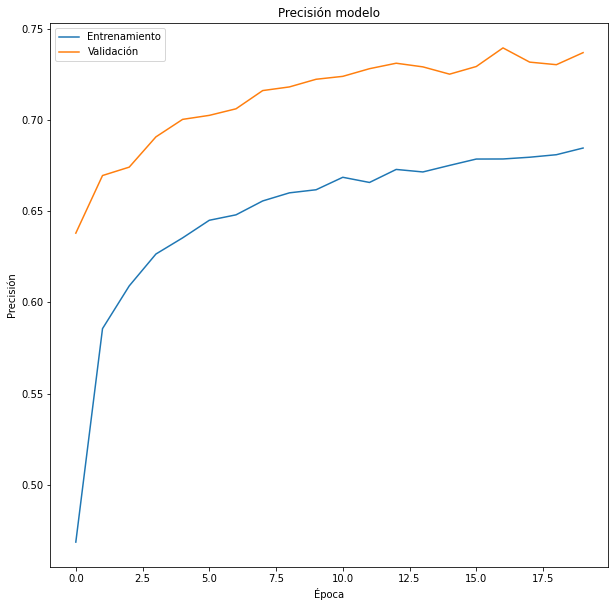

In [ ]:
# Visualizamos la exactitud    73% en validación. Ha mejorado.
import matplotlib.pyplot as plt
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Exactitud modelo')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc="upper left")
plt.show()

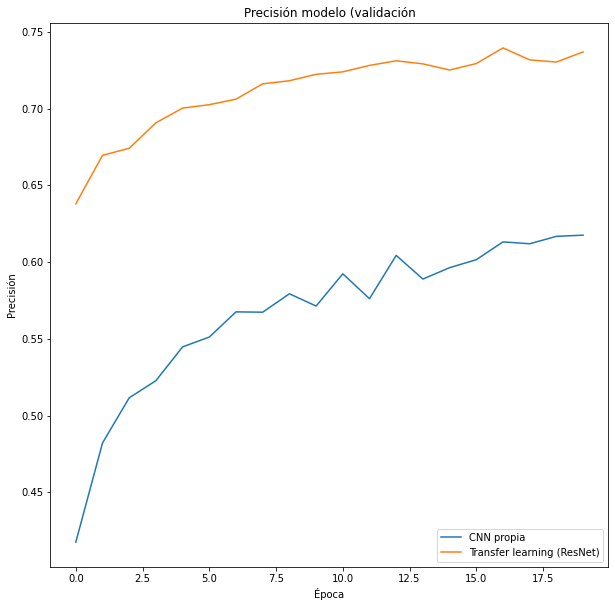

In [ ]:
# Comparativa con modelo inicial
plt.plot(history.history['val_accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('Exactitud modelo (validación')
plt.ylabel('Exactitud')
plt.xlabel('Época')
plt.legend(['CNN propia', 'Transfer learning (ResNet)'], loc="lower right")
plt.show()

In [ ]:
# Evaluamos sobre conjunto de test       74% que no está nada mal.
metrics_resnet = model_resnet.evaluate(X_test_prep, y_test, verbose=0)
print("Exactitud test CNN propia: ", metrics[1])
print("Exactitud test transferencia conocimiento: ", metrics_resnet[1])

Precision test CNN propia:  0.6212000250816345
Precision test transferencia conocimiento:  0.7408000230789185


Podemos observar un aumento en la exactitud.

Tras haber realizado una transferencia de conocimiento congelando las capas del modelo base, se puede hace un ajuste fino del modelo adaptando los pesos de toda la red empleando una tasa de aprendizaje baja durante pocas épocas (para evitar el sobreajuste).  Fine tunning

In [ ]:
from tensorflow.keras.optimizers import Adam
# Descongelamos las capas del modelo base
for layer in base_model.layers:
	layer.trainable = True

# Compilamos el modelo con una tasa de aprendizaje más baja
model_resnet.compile(optimizer=Adam(1e-5),     #le ponemos la tasa de aprendizaje de 10⁻⁵
              loss= 'categorical_crossentropy',
              metrics=['accuracy'])

# Entrenamos modelo durante unas pocas épocas.
history_resnet_fine = model_resnet.fit(X_train_prep, y_train_cod, epochs=10,     #para que NO llegue al sobreajuste, NO se puede entrenar durante muchas épocas.
                                       batch_size=128,
                                       validation_data=(X_val_prep, y_val))

Epoch 1/10
391/391 [==============================] - 34s 70ms/step - loss: 1.1340 - accuracy: 0.6081 - val_loss: 0.8018 - val_accuracy: 0.7232
Epoch 2/10
391/391 [==============================] - 27s 68ms/step - loss: 0.9091 - accuracy: 0.6841 - val_loss: 0.7504 - val_accuracy: 0.7374
Epoch 3/10
391/391 [==============================] - 31s 78ms/step - loss: 0.8454 - accuracy: 0.7068 - val_loss: 0.7161 - val_accuracy: 0.7520
Epoch 4/10
391/391 [==============================] - 29s 73ms/step - loss: 0.8044 - accuracy: 0.7213 - val_loss: 0.6905 - val_accuracy: 0.7604
Epoch 5/10
391/391 [==============================] - 29s 74ms/step - loss: 0.7653 - accuracy: 0.7334 - val_loss: 0.6705 - val_accuracy: 0.7696
Epoch 6/10
391/391 [==============================] - 29s 73ms/step - loss: 0.7412 - accuracy: 0.7446 - val_loss: 0.6548 - val_accuracy: 0.7752
Epoch 7/10
391/391 [==============================] - 29s 74ms/step - loss: 0.7090 - accuracy: 0.7537 - val_loss: 0.6406 - val_accuracy:

In [ ]:
# Evaluamos sobre conjunto de test, del 62% hemos llegado casi al 80%.
metrics_resnet_2 = model_resnet.evaluate(X_test_prep, y_test, verbose=0)
print("Exactitud test CNN propia: ", metrics[1])
print("Exactitud test transferencia conocimiento: ", metrics_resnet_2[1])

Precision test CNN propia:  0.6212000250816345
Precision test transferencia conocimiento:  0.7973999977111816


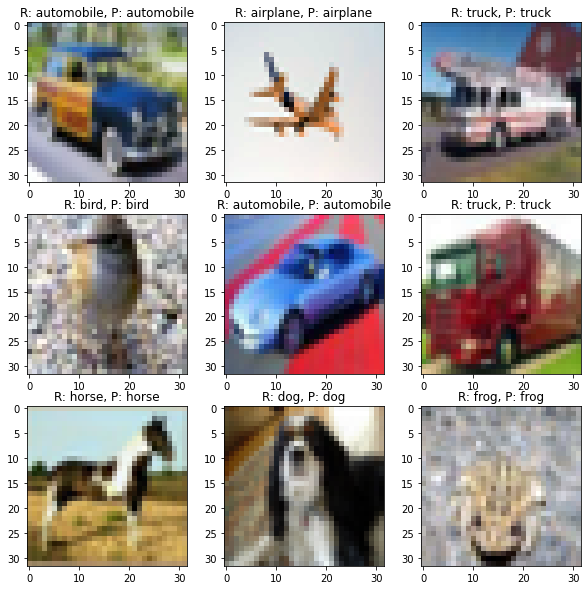

In [ ]:
# Obtenemos predicciones 
prediccion = model_resnet.predict(X_test_prep)
# Cogemos la clase con mayor probabilidad
prediccion = np.argmax(prediccion, axis=1)

# y_test lo tenemos en codificación OneHot, por lo que lo convertimos a clases
y_test_clases = np.argmax(y_test, axis=1)

# Buscamos los índces de las imágenes corretamente e incorrectamente clasificadas
correct_index = np.nonzero(prediccion == y_test_clases)[0]
incorrect_index = np.nonzero(prediccion != y_test_clases)[0]

# Mostramos 9 imágenes correctamente clasificadas
plt.rcParams['figure.figsize'] = (10, 10)
for i, correct in enumerate(correct_index[:9]):
  # Convertimos imagen al rango [0, 1] para visualizarla
  image = X_test[correct]
  for j in range(3):
    image_ch = image[:, :, j]
    image[:, :, j] = (image_ch - image_ch.min()) / (image_ch.max() - image_ch.min())
  plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title(f'R: {classes[int(y_test_clases[correct])]}, P: {classes[int(prediccion[correct])]}')

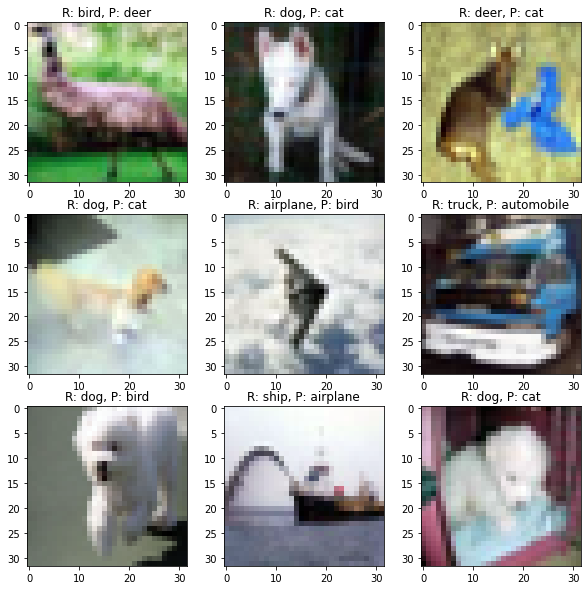

In [ ]:
# Mostramos 9 imágenes incorrectamente clasificadas
plt.rcParams['figure.figsize'] = (10, 10)
for i, incorrect in enumerate(incorrect_index[:9]):
  # Convertimos imagen al rango [0, 1] para visualizarla
  image = X_test[incorrect]
  for j in range(3):
    image_ch = image[:, :, j]
    image[:, :, j] = (image_ch - image_ch.min()) / (image_ch.max() - image_ch.min())
  plt.subplot(3, 3, i+1)
  plt.imshow(image)
  plt.title(f'R: {classes[int(y_test_clases[incorrect])]}, P: {classes[int(prediccion[incorrect])]}')

NO hay que volverse loco diseñando una arquitectura. Ya hay muchas arquitecturas de Redes Neuronales Convolucionales CNN. Las podemos utilizar de base. Para hacer transferencia de conocimiento o inicializarla con los pesos que utilizó y entrenar de cero con todos mis datos. Congelar y aprovechar o inicializar. Ya que tengo una base de datos grande pues entreno todas las capas.

Se puede probar a importar y sin congelar, entrenarla. Mejores resultados que nuestra arquitectura inicial (pero tarda un poco).


Pensad también que NO hemos hecho un análisis previo de los datos. (si están balanceados, número de camiones de los 50.000, ...)